In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN



In [3]:
data = pd.read_csv('../data/processed/data.csv')


In [4]:
X = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label','entropy','acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y = data[['new_label']]
#y = data[['label']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Define function to add Gaussian noise

In [6]:
def add_gaussian_noise(X, noise_level=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return X + noise

In [7]:
# Define k values to test
k_values = [3, 5, 7, 9]

#### Testing oversampling techniques

#### 1. SMOTE

#### With CV

In [8]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)


print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

k=3: Mean CV Accuracy = 0.9554 ± 0.0301
k=5: Mean CV Accuracy = 0.9741 ± 0.0222


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

k=7: Mean CV Accuracy = 0.9518 ± 0.0343
k=9: Mean CV Accuracy = 0.9444 ± 0.0405

Best k: 5 with CV Accuracy = 0.9741

Test set accuracy (best k=5): 0.9556
['bot' 'human']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


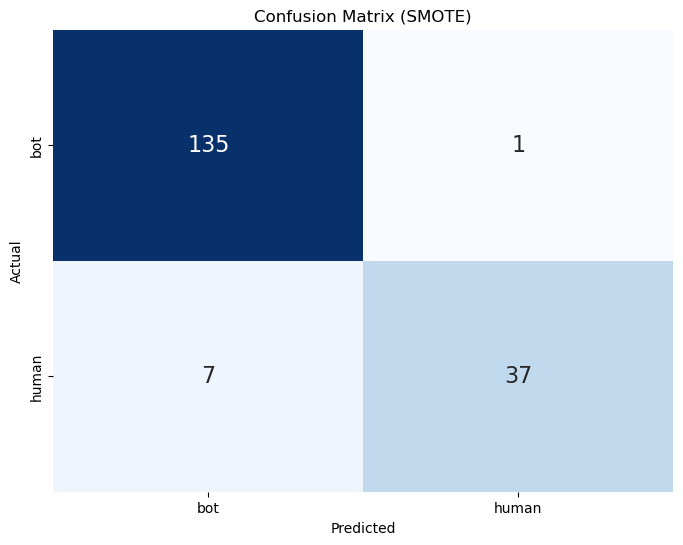

In [748]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTE)')
plt.show()

In [749]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9556


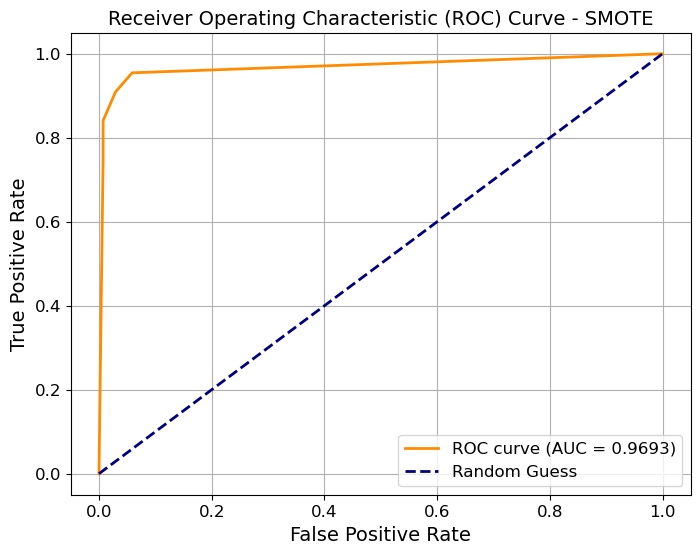

In [750]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

#### 2. Borderline SMOTE

#### With CV

In [751]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9590 ± 0.0320
k=5: Mean CV Accuracy = 0.9591 ± 0.0296
k=7: Mean CV Accuracy = 0.9480 ± 0.0428
k=9: Mean CV Accuracy = 0.9443 ± 0.0523

Best k: 5 with CV Accuracy = 0.9591

Test set accuracy (best k=5): 0.9667
ROC AUC: 0.9712
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

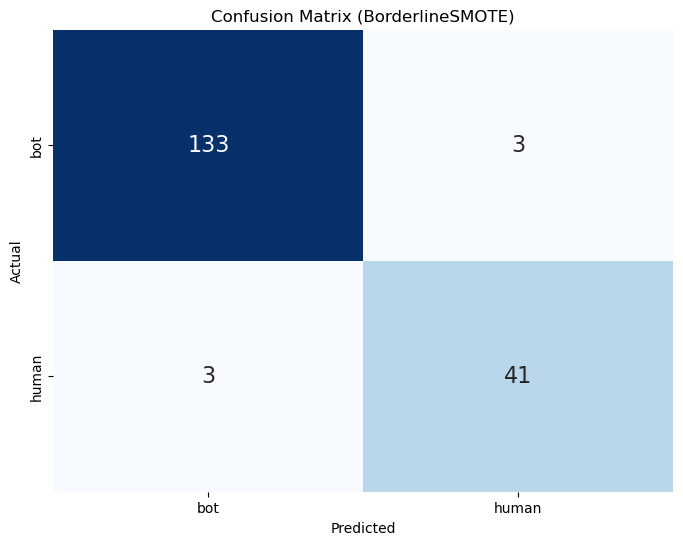

In [752]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (BorderlineSMOTE)')
plt.show()

In [753]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9667


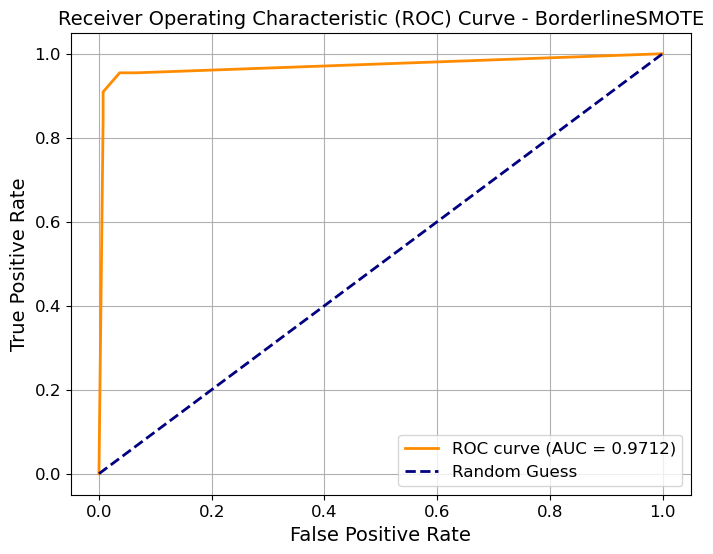

In [754]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - BorderlineSMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

#### 3. ADASYN

#### With CV

In [755]:


# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9554 ± 0.0363
k=5: Mean CV Accuracy = 0.9406 ± 0.0428
k=7: Mean CV Accuracy = 0.9369 ± 0.0491
k=9: Mean CV Accuracy = 0.9369 ± 0.0491

Best k: 3 with CV Accuracy = 0.9554

Test set accuracy (best k=3): 0.9611
ROC AUC: 0.9714
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

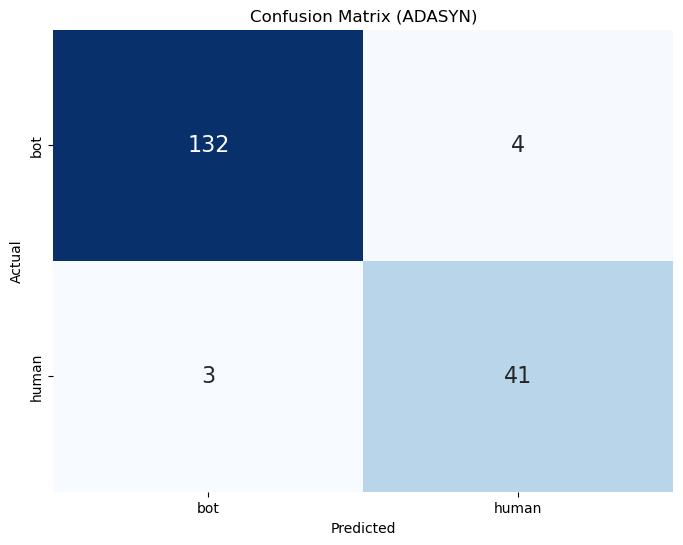

In [756]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ADASYN)')
plt.show()

In [757]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9611


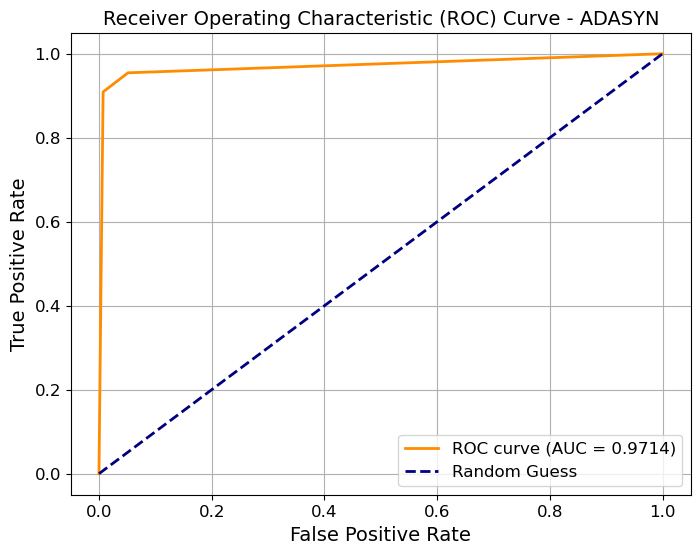

In [758]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - ADASYN', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()